# Traffic Collisions in San Diego since 2017

In this capstone project, we will do an analysis and visaulization of Traffic Collisions in San Diego since 2017. This was of particular interest to me since the dataset is of my local area and could provide some interesting insights given what I know about the dynamic changes in San Diego. While there is a slight risk of outcome bias, I believe having domain knowledge here would only help to either validate the results or challenge my current understanding of the local area.

What are key critical factors that lead to traffic collisions here in San Diego county? What does our dataset offer to us as insights into possible related risks (and what does our dataset lack)? There are numerous questions that we will raise, but let us first begin with a proper introduction of packages and our dataset.

### Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
%pylab inline
from pygeocoder import Geocoder
import folium
from datetime import datetime
from folium.plugins import HeatMap

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Dataset
The following dataset was obtained through the public database for San Diego Traffic: https://data.sandiego.gov/datasets/police-collisions/

In [3]:
df = pd.read_csv('pd_collisions_datasd_v1.csv')

Let's take a look at our dataset and see what information it records:

In [4]:
print('Total Number of Accidents in Database: {}'.format(df.shape[0]))

Total Number of Accidents in Database: 27570


In [5]:
df.sample(3)

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
13342,183499,2018-05-02 12:11:00,722,2200,,CORONADO,AVENUE,,,,22350,VC,VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR ...,1,0,NaN
27097,193544,2019-09-13 14:40:00,512,900,S,28TH,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
14953,185167,2018-06-30 00:44:00,441,3600,,OCEAN VIEW,BOULEVARD,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,NaN


In [6]:
max_record = df.date_time.max()
min_record = df.date_time.min()
print('Records are between {} and {}'.format(min_record, max_record))

Records are between 2017-01-01 00:01:00 and 2019-10-03 01:47:00


In [7]:
# Remove blanks in dataframe with NAN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27570 entries, 0 to 27569
Data columns (total 16 columns):
report_id                    27570 non-null object
date_time                    27570 non-null object
police_beat                  27570 non-null int64
address_number_primary       27570 non-null int64
address_pd_primary           1085 non-null object
address_road_primary         27570 non-null object
address_sfx_primary          25967 non-null object
address_pd_intersecting      61 non-null object
address_name_intersecting    1738 non-null object
address_sfx_intersecting     1538 non-null object
violation_section            27570 non-null object
violation_type               27570 non-null object
charge_desc                  27570 non-null object
injured                      27570 non-null int64
killed                       27570 non-null int64
hit_run_lvl                  12853 non-null object
dtypes: int64(4), object(12)
memory usage: 3.4+ MB


Some interesting questions and prior assumptions come to mind as something to draw insights from our dataset:

1. What are the most common violations leading to traffic collisions? (One might assume DUI's or Speeding)
2. Does the data suggest that traffic collisions are more likely on any given day of the week? (One might assume weekdays or Friday nights...)
3. Does the data suggest that a particular month/season is worse than others? (One might assume during the summer time during tourism season)
4. Does the data suggest that a particular time of day is better/worse than others? (One might assume during rush hours or late night hours)
5. Does the data suggest that certain areas of San Diego are more prone to traffic collisions? (One might assume downtown or metro areas)

Hopefully we are not begging the question too much and, indeed, as our analysis may surprise us with its results!

## 1. Most Common Violations related to Traffic Collisions

In [9]:
df.charge_desc.value_counts()

TURNING MOVEMENTS AND REQUIRED SIGNALS                               6312
MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHICLE CODE               6300
VIOLATION OF BASIC SPEED LAW SPEED UNSAFE FOR CONDITIONS             2899
STARTING PARKED VEHICLES OR BACKING                                  1590
RED OR STOPVEHICLES STOP AT LIMIT LINE                               1271
TURNS:UNSAFE TURN AND/OR NO TURN SIGNAL (I)                           955
FOLLOWING TOO CLOSELY                                                 901
LEFT TURN YIELD UNTIL SAFE OR U-TURN                                  684
UNSAFE SPEED (BASIC SPEED LAW) (I)                                    598
YIELD RIGHT OF WAY TO PEDESTRIANS                                     489
ENTERING HWY FROM PRIVATE ROAD OR DRIVEWAY                            471
ENTRANCE FROM STOP THROUGH HIGHWAYYIELD UNTIL REASONABLY SAFE         423
UNSAFE START ON HWY (I)                                               252
SIGNAL LIGHTS:CIRCULAR RED (I)        

In [10]:
vio_count = df.charge_desc.nunique()
print('Unique types of Violations: {}'.format(vio_count))

Unique types of Violations: 316


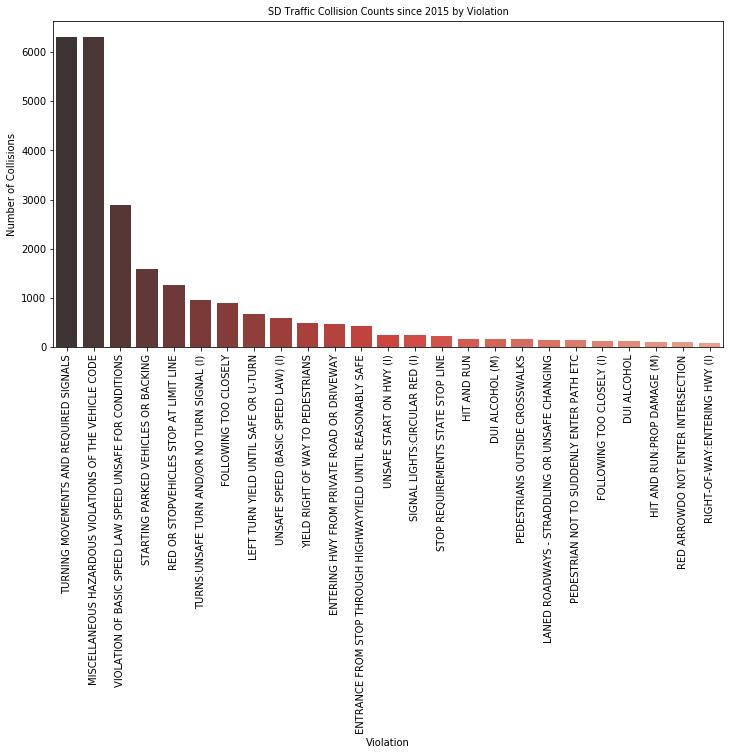

In [11]:
# Create a Violation Counts Dataframe
charge_df = pd.DataFrame(df['charge_desc'].value_counts())
charge_df_top = charge_df.iloc[:25] # Limit our output top 15 results

# Barplot
plt.figure(figsize=(12,6))
ax1 = sns.barplot(data=charge_df_top, x=charge_df_top.index, y='charge_desc', palette=("Reds_d"))

# Formatting
sns.set_context("paper")
plt.title('SD Traffic Collision Counts since 2015 by Violation')
plt.xlabel('Violation')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=90)
plt.show()

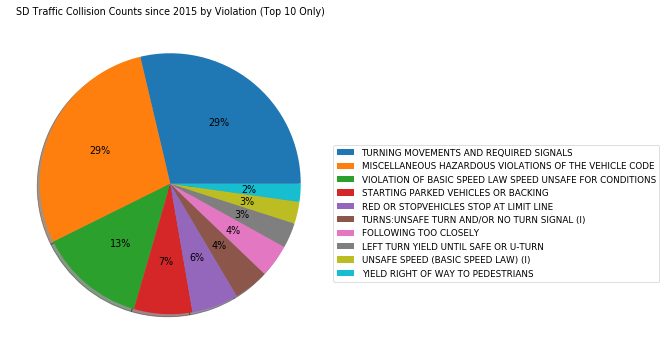

In [12]:
plt.figure(figsize=(12,6))
charge_df_top10 = charge_df.iloc[:10] # Limit our output top 10 results
violation_pie = plt.pie(data=charge_df_top10, x='charge_desc', autopct='%.0f%%', shadow=True)
plt.title('SD Traffic Collision Counts since 2015 by Violation (Top 10 Only)')
plt.legend(charge_df_top10.index, loc=(1,0.2))
plt.show()

Let's check our result here using the general violation section which groups similar violations together under a violation code number. We will find out the top 5 codes, and then translate our top 5 violation codes with the documentation provided in the California Vehicle Code (http://leginfo.legislature.ca.gov):

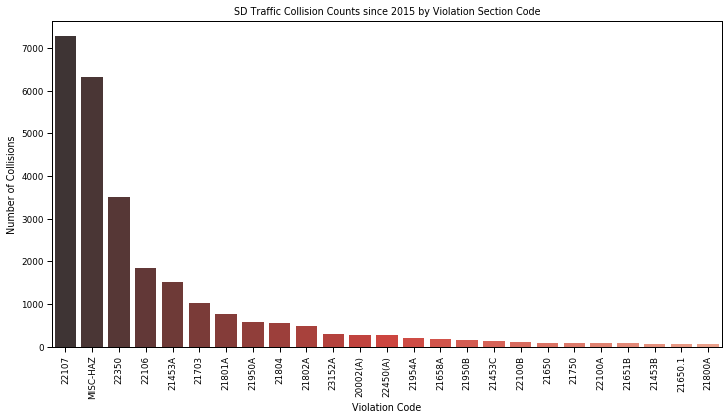

In [13]:
charge_type_df = pd.DataFrame(df['violation_section'].value_counts())

# Create a Violation Type Counts Dataframe
viosec_df = pd.DataFrame(df['violation_section'].value_counts())
viosec_df_top = charge_type_df.iloc[:25] # Limit our output top 15 results

# Barplot
plt.figure(figsize=(12,6))
ax1 = sns.barplot(data=viosec_df_top, x=viosec_df_top.index, y='violation_section', palette=("Reds_d"))

# Formatting
sns.set_context("paper")
plt.title('SD Traffic Collision Counts since 2015 by Violation Section Code')
plt.xlabel('Violation Code')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=90)
plt.show()

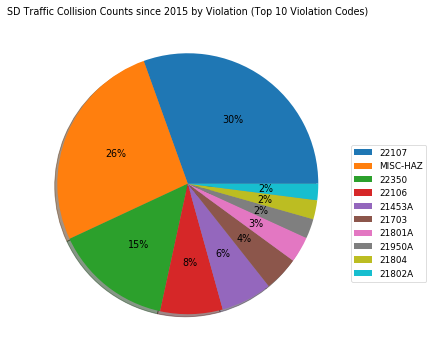

In [14]:
plt.figure(figsize=(12,6))
viosec_df_top10 = viosec_df.iloc[:10] # Limit our output top 10 results
viosec_pie = plt.pie(data=viosec_df_top10, x='violation_section', autopct='%.0f%%', shadow=True)
plt.title('SD Traffic Collision Counts since 2015 by Violation (Top 10 Violation Codes)')
plt.legend(viosec_df.index, loc=(1,0.2))
plt.show()

<b>Code Translations for top 10 Violation Codes</b> (from http://leginfo.legislature.ca.gov:)
1. 22107 - Turn a vehicle from a direct course or move right or left when unreasonable/not using turn signals
2. MISC-HAZ - Miscellaneous Driving Hazards
3. 22350 - Drive a vehicle upon a highway at a speed greater than is reasonable or prudent
4. 22106 - Start/backing a vehicle stopped, standing, or parked on a highway
5. 21453A - Not stopping red signal or at limit line
6. 21703 - Tailgaiting
7. 21801A - Not yielding right-of-way to incoming traffic during turn/u-turn
8. 21950A - Not yielding to pedestrian traffic
9. 21804 - Not yielding right-of-way when merging into traffic
10. 21802A - Not stopping at stop-signs/yielding right-of-way at stop signs

### Insights
We observe the top 5 violations related to traffic collissions are:
1. Turning movements without signaling
2. Misc. hazardous violations (Thanks for recording this so generically SDPD...)
3. Unsafe driving speeds
4. Starting parked vehicles/backing
5. Red or Stopped Vehicles at Limit Line (i.e. Running a Red Light)

Contrary to our prior assumption, DUI's (ranked 21st) don't even constitute the top 10 violations related to traffic collisions* (One should still refrain from driving under the influence). The top violation - turning without signaling - is far more frequent than all other violations. <b>Please people: use your turn signals! And stop driving so fast!</b>

<sub><i>*Note: Skeptical readers may take issue with our dataset that one might want to clean up is to group all types of DUI's in our dataset together and all similar types of violations together. This would take an inordinate amount of time without knowing more about San Diego Police Department's recording policies, and so we will not endeavor on this in this module. Since all violations after the top 25 have frequencies less than <100, as well as the fact that there are only 312 total types of violations, we can likely guess that grouping our data would not likely raise certain categories of violations much higher/lower on our rankings in comparison to the top 5 violation types.

## 2. Most Dangerous Violations
What violations are the most dangerous/deadly? Which ones lead to the most injuries and deaths?

In [15]:
unique_violations = df.violation_section.unique()
totalViolations = []

for violation in unique_violations:
    deadly_vio_df = df[df.violation_section==violation]
    totalViolations.append((violation, sum(deadly_vio_df.injured), sum(deadly_vio_df.killed)))

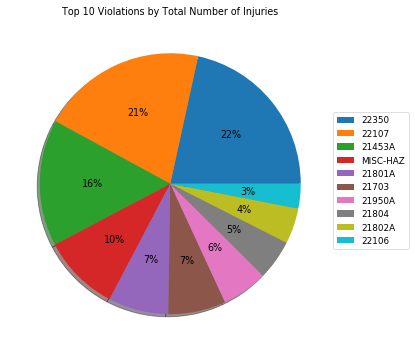

In [16]:
top10_vio_sort_injury = sorted(totalViolations, key=lambda tup: tup[1], reverse = True)[:10]
top10_vio_sort_killed = sorted(totalViolations, key=lambda tup: tup[2], reverse = True)[:10]
top10vio_injury_df = pd.DataFrame(data=top10_vio_sort_injury, columns = ['violation','injured','killed'])
top10vio_killed_df = pd.DataFrame(data=top10_vio_sort_killed, columns = ['violation','injured','killed'])

plt.figure(figsize=(12,6))
plt.title('Top 10 Violations by Total Number of Injuries')
top10_vio_injured_pie = plt.pie(x=top10vio_injury_df.injured, autopct='%.0f%%', shadow=True)
plt.legend(top10vio_injury_df.violation, loc=(1,0.3))
plt.show()

1. 22350 - Speeding
2. 22107 - Unsafe turning or not using turn signals
3. 21453A - 21453A - Not stopping at stop signs
4. MISC-HAZ - Miscellaneous Hazards
5. 21801A - Turning vehicles (left or u-turn) not yielding right of way to incoming traffic
6. 21703 - Tailgaiting
7. 21950A - Not yielding right of way to pedestrians
8. 21804 - Not yielding right of way entering a highway or road
9. 21802A - Not stopping at intersections
10. 22106 - Starting or backing a vehicle stopped, standing, or parked on a highway

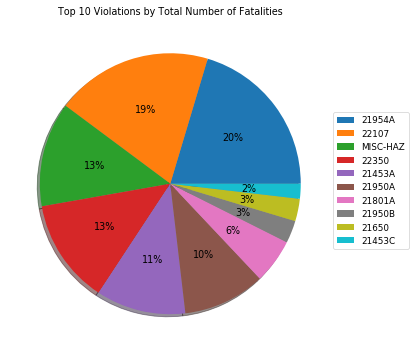

In [17]:
plt.figure(figsize=(12,6))
top10killed = plt.pie(x=top10vio_killed_df.killed, autopct='%.0f%%', shadow=True)
plt.title('Top 10 Violations by Total Number of Fatalities')
plt.legend(top10vio_killed_df.violation, loc=(1,0.3))
plt.show()

1. 21954A - Pedestrians not yielding the right-of-way to all vehicles (e.g. jaywalking)
2. 22107 - Unsafe turning or not using turn signals
3. MISC-HAZ - Miscellaneous Hazards
4. 22350 - Speeding
5. 21453A - Not stopping at stop signs
6. 21950A - Not yielding right of way to pedestrians
7. 21801A - Turning vehicles (left or u-turn) not yielding right of way to incoming traffic
8. 21950B - Pedestrian leaving curb/crosswalk/place of safety into road
9. 21650 - Driving on the wrong side of the road
10. 21453C - Turning at a red light arrow

### Insights
What is of particular interest here is the difference between violations that lead the highest number of injuries vs. the highest number of fatalities. The top 3 violations that lead to injuries in San Diego is speeding, unsafe turning, and not stopping at stop signs, whereas the top 3 violations that lead to fatalities are jaywalking, unsafe turning, and speeding (if we disregard "miscellaneous hazards"). Many of the violations with high fatality counts are pedestrian related.

## 2. Traffic Collision Frequency by Day of the Week

Are certain days of the week better/worse than others in terms of traffic collisions?

In [18]:
date_format = "%Y-%m-%d %H:%M:%S"
max_record = datetime.strptime(df.date_time.max(), date_format)
min_record = datetime.strptime(df.date_time.min(), date_format)

In [19]:
# Calculate number of days in our records to calculate mean
df.date_time = pd.to_datetime(df.date_time)
df["day_of_week"] = df.date_time.dt.dayofweek

delta = max_record - min_record
days_count = delta.days
days = list(range(7))
day_mean_df = pd.DataFrame(columns = ['day','mean'])
day_mean_df.day = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']

def day_stats(day):
    day_mean = df[df['day_of_week']==day].shape[0]/days_count
    return(day_mean)
    
for day in days:
    day_mean_df.loc[day, 'mean'] = day_stats(day)

day_mean_df.transpose()

,0,1,2,3,4,5,6
day,Sun,Mon,Tues,Wed,Thurs,Fri,Sat
mean,3.63682,3.80199,3.89353,3.90448,4.26567,4.09154,3.83881


An initial look at the mean number of traffic collisions seems to suggest that perhaps the middle of our week has a higher number of incidents than the weekends.

In [20]:
df.date_time = pd.to_datetime(df.date_time)

# Count frequency of collisions by weekday / appending a day column
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df["day_of_week"] = df.date_time.dt.dayofweek
week_df = pd.DataFrame(df['day_of_week'].value_counts()).sort_index()
week_df['day'] = weekdays
week_df.columns = ['accident_count', 'week_day']

# Re-order columns
columnsTitles=["week_day","accident_count"]
week_df=week_df.reindex(columns=columnsTitles)
week_df

,week_day,accident_count
0,Sun,3655
1,Mon,3821
2,Tue,3913
3,Wed,3924
4,Thu,4287
5,Fri,4112
6,Sat,3858


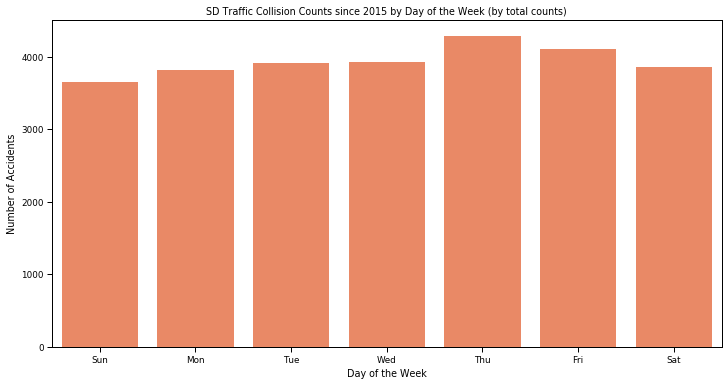

In [21]:
plt.figure(figsize=(12,6))
ax3 = sns.barplot(x='week_day', y='accident_count', color='coral', data=week_df)
ax3.set(xlabel='Day of the Week', ylabel='Number of Accidents')
plt.title('SD Traffic Collision Counts since 2015 by Day of the Week (by total counts)')
plt.show()

### Insights

We observe that the histogram of traffic collision frequency to the day the week seems uniformly distributed, meaning that we would expect the likelihood of a traffic collision to be consistent on any given day of the week*. 

<sub>*Although there might be an argument that there is a rise in traffic collisions during the week as opposed to the weekends. We would need to check the significance via a regression model, which is out of the scope of this particular module. 

## 3. Traffic Collision Frequency by Day of the Month/Season

Are certain months/seasons worse in San Diego in terms of traffic collisions?

In [22]:
# Count frequency of collisions by weekday / appending a month column
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']
df["accident_month"] = df.date_time.dt.month
month_df = pd.DataFrame(df['accident_month'].value_counts()).sort_index()
month_df['month_name'] = months
month_df.columns = ['accident_count', 'month']

# Re-order columns
columnsTitles=["month","accident_count"]
month_df=month_df.reindex(columns=columnsTitles)
month_df

,month,accident_count
1,January,2434
2,February,2242
3,March,2596
4,April,2381
5,May,2427
6,June,2571
7,July,2632
8,August,2530
9,September,2518
10,October,1817


One will quickly notice that the last three months have a disproportionately lower number of accidents. This is not because they are better months; our dataset does not contain 2019's October, November, and December months (they hadn't happened yet). We will instead need to come up with an average accident count by the number of years on record.

In [23]:
month1_df = month_df[0:9]
month1_avg_df = pd.DataFrame(month1_df['accident_count'].div(3))

month2_df = month_df[9:12]
month2_avg_df = pd.DataFrame(month2_df['accident_count'].div(2))

merged_df = pd.merge(month1_avg_df, month2_avg_df, how='outer')
merged_df['month'] = months
merged_df

columnsTitles=["month","accident_count"]
merged_df=merged_df.reindex(columns=columnsTitles)
merged_df

,month,accident_count
0,January,811.333333
1,February,747.333333
2,March,865.333333
3,April,793.666667
4,May,809.000000
5,June,857.000000
6,July,877.333333
7,August,843.333333
8,September,839.333333
9,October,908.500000


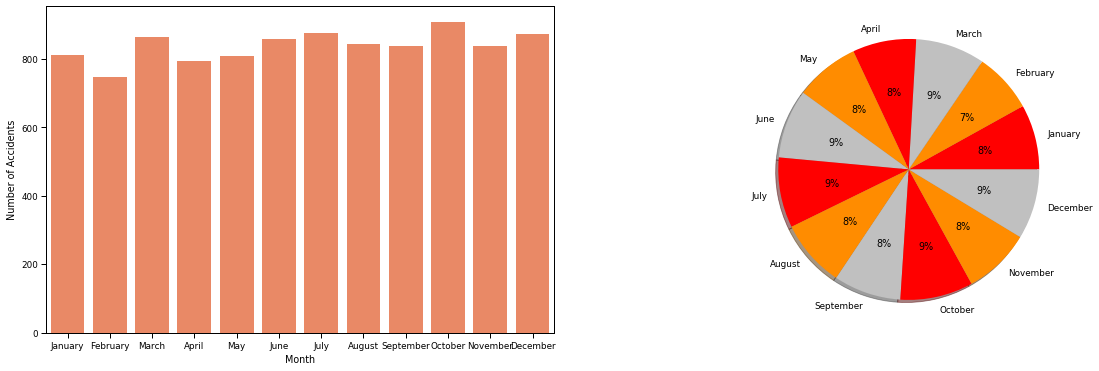

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax4a = sns.barplot(x='month', y='accident_count', color='coral', data=merged_df, ax = axes[0])
ax4a.set(xlabel='Month', ylabel='Number of Accidents')
ax4b = plt.pie(x=merged_df.accident_count, labels=months, colors=['red', 'darkorange', 'silver'], autopct='%.0f%%', shadow=True)
plt.show()

The data of traffic collisions is somewhat uniformly spread across the months, and our pie chart seems to support this. February might have less traffic collisions simply because it is a shorter month. If we were to take the number of days into consideration for each month, it might normalize our data even more (an interesting consideration).

In [25]:
winter_df = pd.DataFrame(merged_df.iloc[[0,1,11],[1]].sum())
spring_df = pd.DataFrame(merged_df.iloc[[2,3,4],[1]].sum())
summer_df = pd.DataFrame(merged_df.iloc[[5,6,7],[1]].sum())
fall_df = pd.DataFrame(merged_df.iloc[[8,9,10],[1]].sum())

In [26]:
season1_df = pd.merge(winter_df, spring_df, how='outer')
season2_df = pd.merge(summer_df, fall_df, how='outer')
season_df = pd.merge(season1_df, season2_df, how='outer')
season_df['season'] = ['winter', 'spring', 'summer', 'fall']
season_df.rename(columns={0:'accident_count'}, inplace=True)
season_df = season_df.reindex(columns=['season','accident_count'])
season_df

,season,accident_count
0,winter,2431.666667
1,spring,2468.000000
2,summer,2577.666667
3,fall,2585.833333


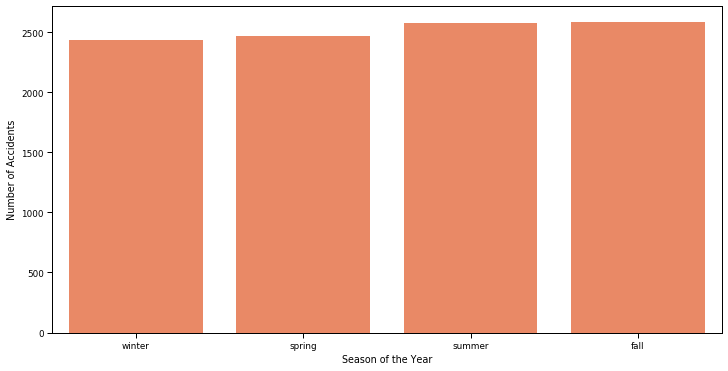

In [27]:
plt.figure(figsize=(12,6))
ax5 = sns.barplot(x='season', y='accident_count', color='coral', data=season_df)
ax5.set(xlabel='Season of the Year', ylabel='Number of Accidents')
plt.show()

### Insights
This only further confirms our suspcion that perhaps months/seasons don't matter in terms of varying traffic collisions in San Diego - perhaps an unexpected result given how much tourism there exists in San Diego.

## 4. Traffic Collision Frequency by Time of Day

Does the data suggest that a particular time of day is better/worse than others?

In [28]:
df["hour"] = df.date_time.dt.hour
print('The Mean Hour for Traffic Collisions: {number:.{digits}f}'.format(number=df.hour.mean(), digits=2))
print('The Median Hour for Traffic Collisions: {}'.format(df.hour.median()))
print('The Standard Deviation for Traffic Collisions: {number:.{digits}f}'.format(number=df.hour.std(), digits=2))
df.hour.describe()

The Mean Hour for Traffic Collisions: 12.76
The Median Hour for Traffic Collisions: 14.0
The Standard Deviation for Traffic Collisions: 6.51


count    27570.000000
mean        12.755386
std          6.512561
min          0.000000
25%          8.000000
50%         14.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

Our mean is rather low here - that may be due to the high number of outlier reports that have 00:00 reported in our datset. We should instead consider using the median as our indicator of central tendency. Let's move on to some visualizations of our data in regards to the time of day:

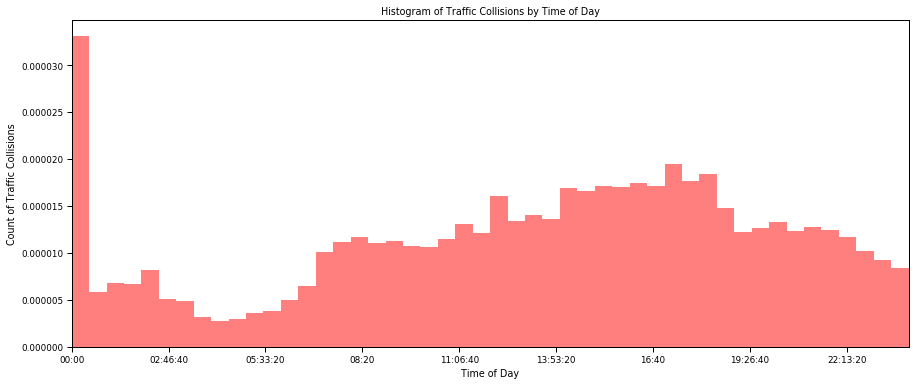

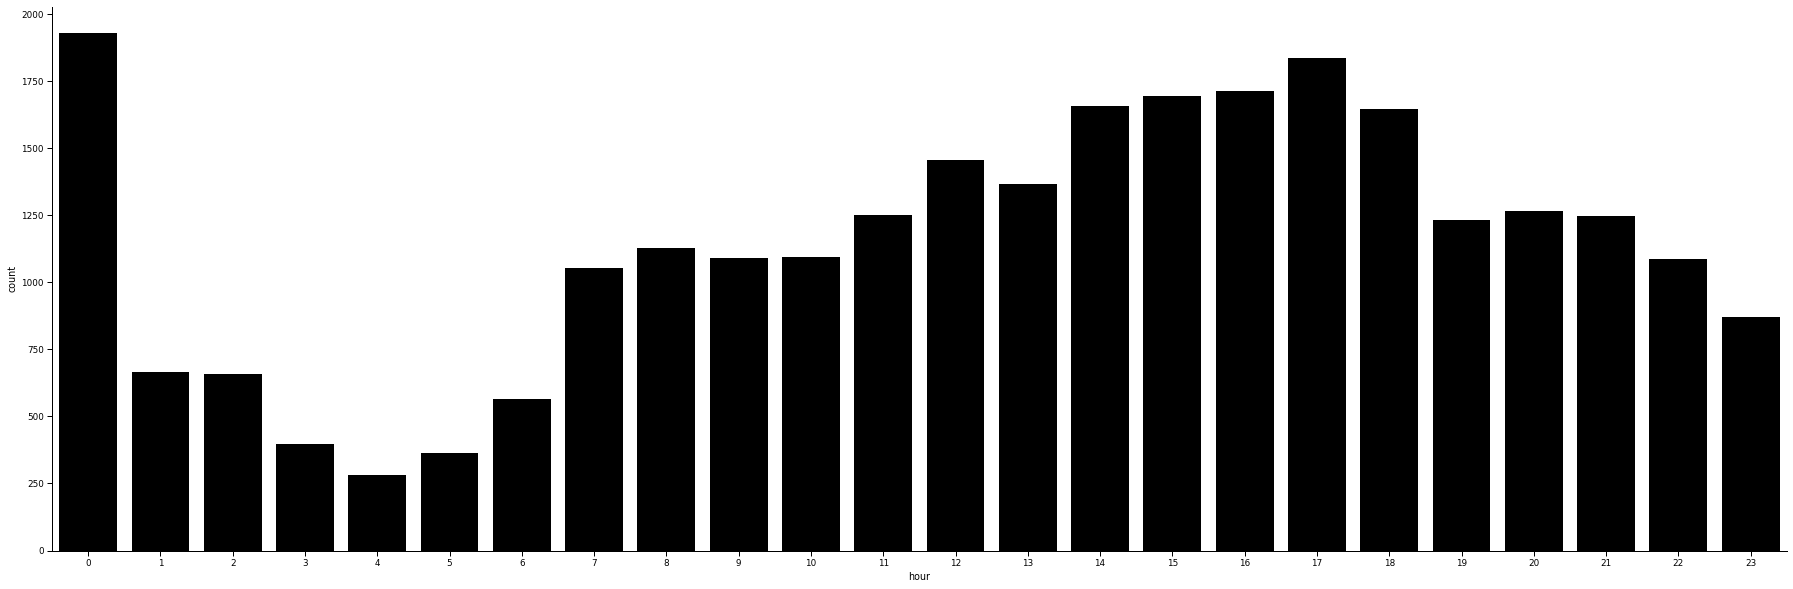

In [29]:
df["time"] = df.date_time.dt.time

plt.figure(figsize=(15,6))

ax_time_hist = plt.hist(df.time, bins=48, normed=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none')
plt.title('Histogram of Traffic Collisions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count of Traffic Collisions')
plt.xlim(0, df.time.max())
sns.catplot(x='hour',
           kind='count',
            height=8.27, 
            aspect=3,
            color='black',
           data=df)
plt.show()



### Box and Violin Plots

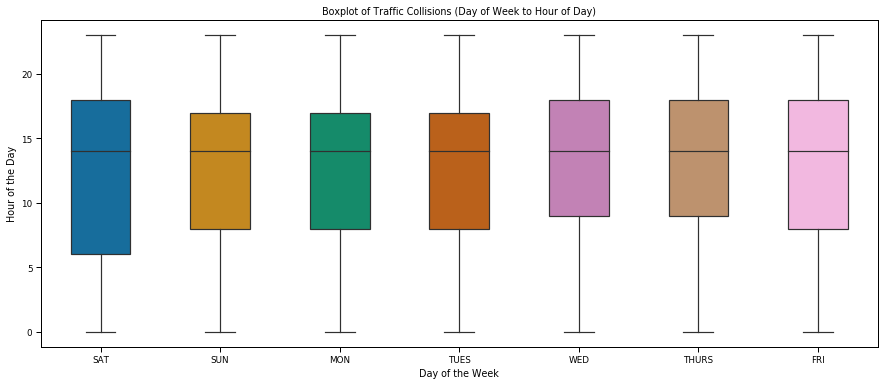

In [30]:
plt.figure(figsize=(15,6))
df["hour"] = df.date_time.dt.hour
day_dict = {0:'SUN', 1:'MON', 2:'TUES', 3:'WED', 4:'THURS', 5:'FRI', 6:'SAT'}
df['day_of_week_name'] = df['day_of_week'].map(day_dict)
day_time_bplot = sns.boxplot(y='hour', x='day_of_week_name', data=df, width=0.5, palette='colorblind')
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day")
plt.title("Boxplot of Traffic Collisions (Day of Week to Hour of Day)")
plt.show()

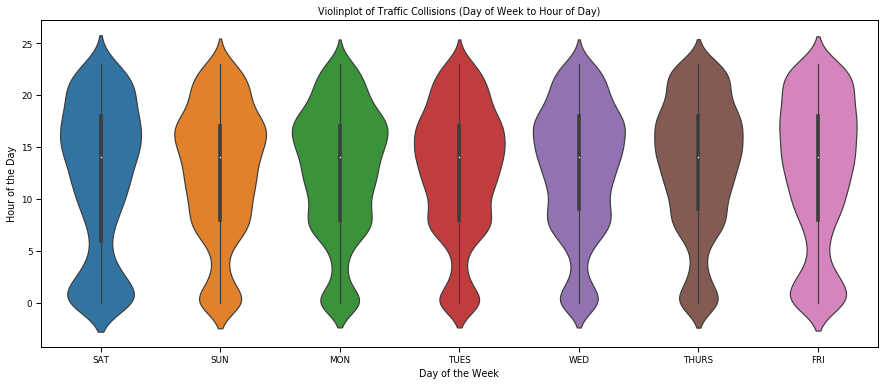

In [31]:
plt.figure(figsize=(15,6))
day_time_vioplot = sns.violinplot(x='day_of_week_name', y='hour', data=df)
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day")
plt.title("Violinplot of Traffic Collisions (Day of Week to Hour of Day)")
plt.show()

### Ingishts

First of all, it looks like the time for 00:00:00 is used as a placeholder when times are not known, so we will throw out that data in our initial consideration. From our graph above, it looks like poor times to drive (i.e. higher risk of traffic collision) would be around our rush hour times in San Diego (around 7AM-930AM and 3PM-6PM). As evenings progress, the frequency starts to mellow down and spikes gently around 1AM. It would be interesting to find out more about SDPD's reporting process and find out what would constiute as a 00:00 automatically (perhaps an accident is not reported until the next day's business hours?).

## 6. Violations by Geography
What areas of San Diego are most prone to traffic collisions?

This is perhaps the most difficult part of our analysis, as we will need to convert addresses in our dataset to latitude and longitude coordinates using geopy and geopandas. This is known as <i>geocoding</i>. The entire process took nearly 13 hours to complete, and a new .csv file was generated from a new dataframe that contains the geocoded dataset.

In [32]:
import geopy
import geopandas

In [33]:
# Replace NAN with empty string
df1 = df.replace(np.nan, '', regex=True)
df1["address_number_primary"]= df1["address_number_primary"].astype(str)

In [34]:
df1['full_address'] = pd.DataFrame(df1['address_number_primary']+' '+df1['address_pd_primary']+' '+df1['address_road_primary']+' '+df1['address_sfx_primary']+', SAN DIEGO, CALIFORNIA, USA')

### Geocoding
We will not run the following code now, as it took aroudn 13 hours to geocode our dataset. We will simply read a new .csv that I made with the addresses converted to lattitude and longitude (many thanks to Abdishakur for his tutorial found at https://towardsdatascience.com/geocode-with-python-161ec1e62b89). The code below is used as reference:



```from geopy.extra.rate_limiter import RateLimiter1```

```from geopy.geocoders import Nominatim```

`locator = Nominatim(user_agent='myGeocoder', timeout=10)`

`nom=Nominatim(domain='localhost:8080', scheme='http')`

`geocode = RateLimiter(locator.geocode, min_delay_seconds=1)`

`df1['location'] = df1['full_address'].apply(geocode)`

`df1['point'] = df1['location'].apply(lambda loc: tuple(loc.point) if loc else None)`

`df1[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df1['point'].tolist(), index=df1.index)`

`export_csv = df1.to_csv(r'C:\Users\edcha\Documents\Work Files\Thinkful Data Science Bootcamp\Capstone 1\geocoded_pd_collisions_dataset.csv', index = None, header=True)`

In [35]:
geo_df = pd.read_csv('geocoded_pd_collisions_dataset.csv')
geo_df

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,...,accident_month,hour,time,day_of_week_name,full_address,latitude,longitude,location,point,altitude
0,170082,2017-01-01 00:01:00,935,5500,NaN,VALERIO,TRAIL,NaN,NaN,NaN,...,1,0,00:01:00,SAT,"5500 VALERIO TRAIL, SAN DIEGO, CALIFORNIA, USA",32.962330,-117.201447,"5500, Valerio Trail, Pacific Highlands Ranch, ...","(32.96233, -117.201447, 0.0)",0.0
1,170166,2017-01-01 00:01:00,124,8300,NaN,CAM DEL ORO,NaN,NaN,NaN,NaN,...,1,0,00:01:00,SAT,"8300 CAM DEL ORO , SAN DIEGO, CALIFORNIA, USA",NaN,NaN,NaN,NaN,NaN
2,170101,2017-01-01 00:01:00,322,6400,NaN,CRAWFORD,STREET,NaN,NaN,NaN,...,1,0,00:01:00,SAT,"6400 CRAWFORD STREET, SAN DIEGO, CALIFORNIA, USA",32.789919,-117.093968,"6400, Crawford Street, Grantville, San Diego, ...","(32.789919, -117.093968, 0.0)",0.0
3,170218,2017-01-01 00:01:00,325,8100,NaN,ROYAL GORGE,DRIVE,NaN,NaN,NaN,...,1,0,00:01:00,SAT,"8100 ROYAL GORGE DRIVE, SAN DIEGO, CALIFORNIA...",32.814888,-117.051316,"8100, Royal Gorge Drive, Navajo, San Diego, Sa...","(32.814888, -117.051316, 0.0)",0.0
4,170220,2017-01-01 01:00:00,524,1000,NaN,A,STREET,NaN,NaN,NaN,...,1,1,01:00:00,SAT,"1000 A STREET, SAN DIEGO, CALIFORNIA, USA",33.043641,-116.870011,"1000, A Street, Ramona, San Diego County, Cali...","(33.043641, -116.870011, 0.0)",0.0
5,170097,2017-01-01 01:00:00,521,1000,NaN,11TH,AVENUE,NaN,NaN,NaN,...,1,1,01:00:00,SAT,"1000 11TH AVENUE, SAN DIEGO, CALIFORNIA, USA",32.715852,-117.154797,"1000, 11th Avenue, East Village, Banker's Hill...","(32.715852, -117.154797, 0.0)",0.0
6,170153,2017-01-01 01:18:00,437,2600,NaN,RAMFOS,PLACE,NaN,NaN,NaN,...,1,1,01:18:00,SAT,"2600 RAMFOS PLACE, SAN DIEGO, CALIFORNIA, USA",32.679867,-117.042525,"2600, Ramfos Place, Bay Terraces, San Diego, S...","(32.679867, -117.042525, 0.0)",0.0
7,170035,2017-01-01 01:53:00,935,3900,NaN,DE LA VALLE,NaN,NaN,NaN,NaN,...,1,1,01:53:00,SAT,"3900 DE LA VALLE , SAN DIEGO, CALIFORNIA, USA",NaN,NaN,NaN,NaN,NaN
8,170044,2017-01-01 01:58:00,115,9100,NaN,SYDNEY,COURT,NaN,NaN,NaN,...,1,1,01:58:00,SAT,"9100 SYDNEY COURT, SAN DIEGO, CALIFORNIA, USA",32.872651,-117.202073,"Sydney Court, La Jolla Crossroads, University ...","(32.8726508, -117.2020734, 0.0)",0.0
9,170041,2017-01-01 02:00:00,122,900,NaN,EMERALD,STREET,NaN,NaN,NaN,...,1,2,02:00:00,SAT,"900 EMERALD STREET, SAN DIEGO, CALIFORNIA, USA",32.798947,-117.254116,"900, Emerald Street, Crown Point, Pacific Beac...","(32.798947, -117.254116, 0.0)",0.0


In [36]:
import requests
import urllib.request
import time

def loc(streetA, streetB):
    try:
        res = requests.get('https://www.google.com/maps/place/'+streetA+' & '+streetB)
        return re.findall(r'll=(.*?)" item', res.text)[0].split(',')
    except:
        pass

In [37]:
geo_int_df = geo_df[geo_df['address_number_primary']==0]
geo_int_df['full_intersecting_address'] = geo_df['address_pd_intersecting'].fillna('')+' '+geo_df['address_name_intersecting'].fillna('')+' '+geo_df['address_sfx_intersecting']
geo_int_df['full_address'] = geo_df['address_road_primary'].fillna('')+' '+geo_df['address_sfx_primary'].fillna('')

In [38]:
geo_int_df['new_coord'] = geo_int_df.apply(lambda geo_int_df : loc(geo_int_df["full_address"], geo_int_df["full_intersecting_address"]), axis=1)

In [39]:
# Create basic Folium collision map
collision_map = folium.Map(location=[32.7167, -117.1661],
                       tiles = "Stamen Toner",
                      zoom_start = 10.2)

# Add data for heatmap 
geo_heatmap = geo_df[['latitude','longitude']]
geo_heatmap = geo_df.dropna(axis=0, subset=['latitude','longitude'])
geo_heatmap = [[row['latitude'],row['longitude']] for index, row in geo_heatmap.iterrows()]
HeatMap(geo_heatmap, radius=10).add_to(collision_map)
collision_map

### Insights
Interesting observations from our folium heatmap:
1. Districts that have a high number of traffic collisions, 
ocean view and market 

## Looking Ahead